In [1]:
# Import 
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
# Get CUDA
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


The code will run on GPU.


In [3]:
# Define Hotdog data class
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

In [17]:
# Load data
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                      transforms.RandomRotation(degrees=50),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor()])

train_transform1 = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])
            
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 16
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)


CNN

In [30]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=11,stride=1,padding='same'),
                nn.ReLU(),
                nn.BatchNorm2d(num_features=32),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=7,stride=1,padding='same'),
                nn.ReLU(),
                nn.BatchNorm2d(num_features=64),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,stride=1,padding='same'),
                nn.ReLU(),
                nn.Dropout(0.4)
                )

        self.fully_connected = nn.Sequential(
                nn.Linear(32*32*128, 5000),
                nn.ReLU(),
                nn.Linear(5000, 1000),
                nn.ReLU(),
                nn.Linear(1000,2),
                nn.Sigmoid())
    
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [31]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

#Get the first minibatch
data = next(iter(train_loader))[0].cuda()
#Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
model(data); #if this runs the model dimensions fit

Shape of the output from the convolutional part torch.Size([16, 128, 32, 32])


In [32]:
#!nvidia-smi

In [34]:
num_epochs = 10
test_im = []
targ_im = []
pred_im = []

train_accList = []
test_accList = []
for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = F.cross_entropy(output, target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        
        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    #Comput the test accuracy
    test_correct = 0
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target==predicted).sum().item()
        
        if epoch == (num_epochs-1):
            # Save for image displaying
            test_im.append(data)
            targ_im.append(target)
            pred_im.append(predicted)
    
    train_acc = train_correct/len(trainset)
    test_acc = test_correct/len(testset)
    train_accList.append(train_acc)
    test_accList.append(test_acc)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))
    

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Accuracy train: 77.2%	 test: 68.2%


  0%|          | 0/128 [00:00<?, ?it/s]

Accuracy train: 76.6%	 test: 68.4%


  0%|          | 0/128 [00:00<?, ?it/s]

Accuracy train: 78.5%	 test: 70.2%


  0%|          | 0/128 [00:00<?, ?it/s]

Accuracy train: 78.2%	 test: 70.8%


  0%|          | 0/128 [00:00<?, ?it/s]

Accuracy train: 79.0%	 test: 69.7%


  0%|          | 0/128 [00:00<?, ?it/s]

Accuracy train: 79.6%	 test: 70.7%


  0%|          | 0/128 [00:00<?, ?it/s]

Accuracy train: 80.5%	 test: 67.7%


  0%|          | 0/128 [00:00<?, ?it/s]

Accuracy train: 79.6%	 test: 68.4%


  0%|          | 0/128 [00:00<?, ?it/s]

Accuracy train: 79.3%	 test: 69.0%


  0%|          | 0/128 [00:00<?, ?it/s]

Accuracy train: 79.2%	 test: 69.0%


Text(0, 0.5, 'Accuracy')

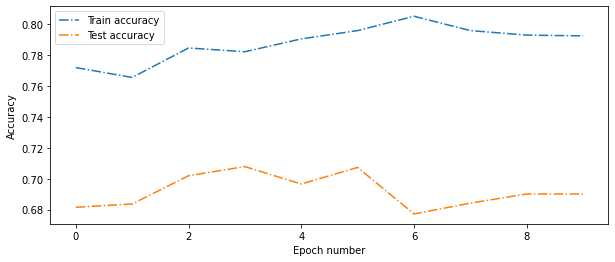

In [36]:
xran = range(epoch+1)
fig = plt.subplots(1,figsize=(10,4))
plt.plot(xran,train_accList,'-.',label='Train accuracy')
plt.plot(xran,test_accList,'-.',label='Test accuracy')
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

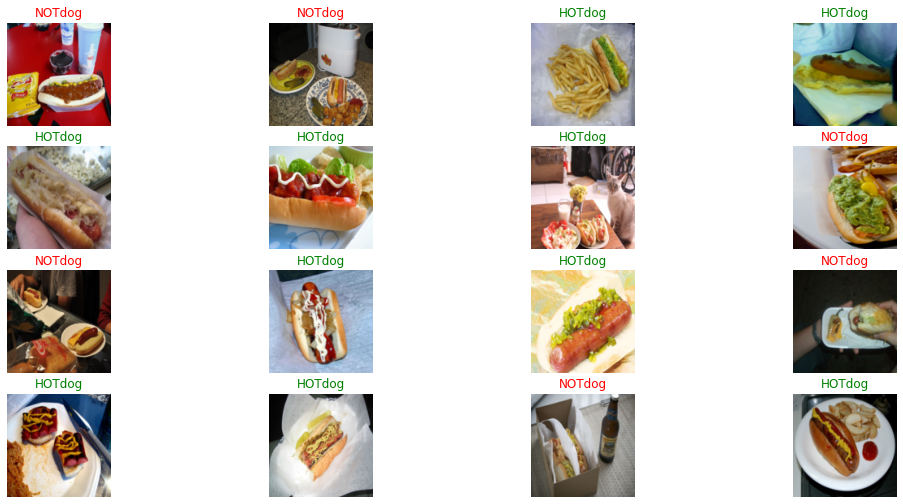

In [10]:
import random
### Lets print the test images with prediction as label (from last iteration)
# Choose random k to select random test set to display
k = random.randint(0,len(pred_im))
im_copy = test_im[k].cpu()
im_copy = im_copy.numpy()
fig = plt.subplots(figsize=(18,11))
for i in range(len(im_copy)):
    plt.subplot(5,4,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(im_copy[i,:,:,:], 0, 2), 0, 1))
    if pred_im[k][i].item() == targ_im[k][i].item():
        plt.title(['HOTdog', 'NOTdog'][pred_im[k][i].item()],color='green')
    else:
        plt.title(['HOTdog', 'NOTdog'][pred_im[k][i].item()],color='red')
    plt.axis('off')


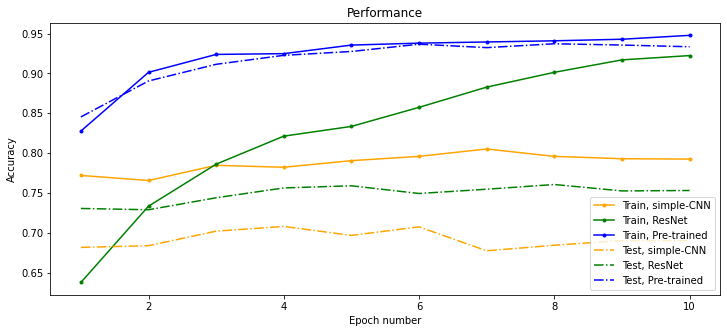

In [55]:
train_acc_JC = train_accList
train_acc_Kel = [0.6375183194919394,0.7332681973619931,0.7860283341475329,0.8212017586712261,0.8334147532975086,0.857352222765022,0.8827552515876893,0.9013190034196384,0.9169516365412799,0.9223253541768441]
train_acc_Nico = [0.827552515876893,0.9013190034196384,0.923790913531998,0.9247679531021006,0.9355153883732291,0.9379579872984856,0.9394235466536395,0.9408891060087934,0.9428431851489986,0.9477283829995115]
test_acc_JC = test_accList
test_acc_Kel = [0.7303974221267454,0.7287862513426423,0.7438238453276047,0.7561761546723953,0.7588614393125671,0.7491944146079484,0.7545649838882922,0.7604726100966702,0.7524167561761547,0.7529538131041891]
test_acc_Nico = [0.8453276047261009,0.8904403866809882,0.9113856068743287,0.9226638023630505,0.9274973147153598,0.9366272824919442,0.9323308270676691,0.9371643394199786,0.9355531686358755,0.9334049409237379]

xran = range(1,len(train_acc_JC)+1)

fig = plt.subplots(1, figsize=(12,5))
plt.plot(xran,train_acc_JC,'.-',label='Train, simple-CNN',color='orange')
plt.plot(xran,train_acc_Kel,'.-',label='Train, ResNet',color='green')
plt.plot(xran,train_acc_Nico,'.-',label='Train, Pre-trained',color='blue')
plt.plot(xran,test_acc_JC,'-.',label='Test, simple-CNN',color='orange')
plt.plot(xran,test_acc_Kel,'-.',label='Test, ResNet',color='green')
plt.plot(xran,test_acc_Nico,'-.',label='Test, Pre-trained',color='blue')
plt.legend()
plt.title('Performance')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

plt.savefig('performance.png')